## Agent Supervisor Example

- collaboration 예제의 경우 에이전트 출력에 따라 자동으로 라우팅됨
- LLM을 사용하여 다양한 에이전트를 오케스트레이션 가능
- 작업을 위임하는데 도움을 주는 에이전트 감독관과 함께 에이전트 그룹 생성 가능

In [ ]:
import dotenv
dotenv.load_dotenv()

## Create Tools
- 검색 엔진을 사용하는 웹 리서치 에이전트와 그래프를 생성하는 에이전트 생성

In [1]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool

tavily_tool = TavilySearchResults(max_results=5)

python_repl_tool = PythonREPLTool()

## Helper Utilities

그래프에서 노드를 생성하는데 필요한 헬퍼 함수 정의
- 이 함수는 에이전트의 응답을 사람의 메세지로 변환하는 작업 처리

In [3]:
from langchain_core.messages import HumanMessage

def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["messages"][-1].content, name=name)]}

state: LangGraph에서 노드가 실행될 때 전달되는 현재 상태(예: 이전까지의 대화 내용 등)를 의미합니다.

agent: 어떤 LangChain Agent 또는 Runnable 객체. invoke(state)를 호출해 현재 상태에 따라 다음 응답을 생성합니다.

result: agent.invoke(state)의 결과로, 일반적으로 {"messages": [...]} 형태의 딕셔너리입니다.

result["messages"][-1].content: 마지막 메시지의 콘텐츠 (즉, LLM이 생성한 응답).

HumanMessage(content=..., name=...): 마지막 메시지를 HumanMessage 형태로 감싸고, name을 부여합니다. 이건 LangGraph에서 메시지 라우팅 또는 multi-agent 환경에서 출처 구분할 때 사용됩니다.

이 메시지를 리스트로 감싼 후, {"messages": [...]} 형태로 반환합니다.

## Create Agent Supervisor

이 함수는 함수 호출(function calling)을 사용하여 다음 작업자 노드를 선택하거나 처리를 완료(finish)합니다.

In [15]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from enum import Enum
from pydantic import BaseModel
from typing import Literal

# 멀테이에전트에 참여하는 에이전트 정의
members = ["Researcher", "Coder"]

# supervisor 에이전트 시스템 프롬프트 정의
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

options = ["FINISH"] + members

# supervisor가 반환할 응답 타입 정의
# llm.with_structured_output(...)에서 자동으로 파싱
class routeResponse(BaseModel):
    next: Literal["FINISH", "Researcher", "Coder"]

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

llm = ChatOpenAI(model="gpt-4o", streaming=True)

def supervisor_agent(state):
    supervisor_chain = (
        prompt
        | llm.with_structured_output(routeResponse)
    )
    return supervisor_chain.invoke(state)

In [7]:
# 다음 작업자들 간의 대화를 관리하는 관리자로서 당신은 다음 작업을 수행해야 합니다: {members}.
# 아래의 사용자 요청을 참고하여, 다음 작업을 수행할 작업자를 지정하세요.
# 각 작업자는 작업을 수행하고 그 결과와 상태를 보고할 것입니다.
# 모든 작업이 완료되면 "FINISH"로 응답하세요.

# 위 대화를 참고하여, 누가 다음으로 행동해야 하나요?
# 아니면 작업을 FINISH해야 하나요?
# 다음 중 하나를 선택하세요: {options}

## Construct Graph

In [8]:
import functools
import operator
from typing import Sequence, TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent

# messages: 여러 Agent 간의 대화를 담는 리스트입니다.
# Annotated[..., operator.add]: 각 노드의 출력 메시지를 누적해서 유지하는 방식
# next: Supervisor가 선택한 다음 작업 대상 ("Researcher", "Coder", "FINISH")
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    next: str

# LangChain의 ReAct 기반 Agent 생성
research_agent = create_react_agent(llm, tools=[tavily_tool])
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

code_agent = create_react_agent(llm, tools=[python_repl_tool])
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", code_node)
workflow.add_node("supervisor", supervisor_agent)

그래프 엣지 연결

In [9]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
# Finally, add entrypoint
workflow.add_edge(START, "supervisor")

graph = workflow.compile()

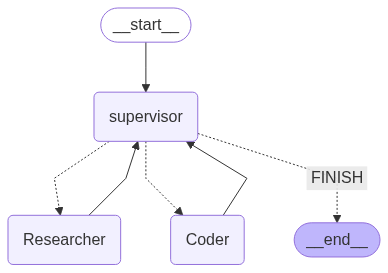

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Invoke the team

In [12]:
for s in graph.stream(
    {
        "messages":[
            HumanMessage(content="Code hello world and print it to the terminal")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'Coder'}}
---


Python REPL can execute arbitrary code. Use with caution.


{'Coder': {'messages': [HumanMessage(content='The code to print "Hello, World!" to the terminal is simply:\n\n```python\nprint(\'Hello, World!\')\n```\n\nWhen you execute this code, it will display:\n\n```\nHello, World!\n```', additional_kwargs={}, response_metadata={}, name='Coder')]}}
---
{'supervisor': {'next': 'FINISH'}}
---


In [14]:
for s in graph.stream(
    {"messages": [HumanMessage(content="사막여우에 대한 간략한 리포트를 한글로 작성해줘.")]},
    {"recursion_limit": 10},
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Researcher'}}
----
{'Researcher': {'messages': [HumanMessage(content='사막여우, 또는 페넥여우(Vulpes zerda)는 작고 귀여운 외모로 잘 알려진 여우로, 북아프리카의 사하라 사막과 아라비아 반도에 주로 서식합니다. 이 동물의 가장 두드러진 특징은 거대한 귀인데, 이는 체온 조절과 사막 환경에서의 열 방출에 도움을 줍니다.\n\n사막여우는 야행성 동물로 낮 동안은 땅 속의 굴에서 더위를 피하고, 밤에 활동하여 먹이를 구합니다. 이들은 주로 곤충, 작은 포유류, 새, 그리고 식물 등을 먹으며, 물이 부족한 환경에서도 몸에 수분을 유지할 수 있도록 진화하였습니다.\n\n이 동물은 사회적이며 가족 단위로 무리를 지어 생활합니다. 사막여우는 총명하며 사람들에게도 비교적 친근한 모습을 보이는 것으로 알려져 있어 일부 지역에서는 애완동물로도 기르는 경우가 있습니다.\n\n현재 사막여우는 그 서식 환경이 위협받고 있어 보호가 필요한 상황입니다. 인간 활동에 따른 서식지 파괴와 애완동물 시장을 위한 포획이 문제로 지적되고 있습니다. 그래서 국제적으로 사막여우를 보호하기 위한 다양한 노력이 이뤄지고 있습니다.', additional_kwargs={}, response_metadata={}, name='Researcher')]}}
----
{'supervisor': {'next': 'FINISH'}}
----
